### Init

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import json
import cv2
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as patches
%matplotlib inline
import os

import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import save_image
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import glob
import PIL
from PIL import Image
from torch.utils import data as D
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.utils.data.sampler import SubsetRandomSampler
import random
from torch.autograd import Variable

### Data

In [0]:
train_json = "/content/drive/Shared drives/EECS545/unzipped_files/malaria/training.json"
test_json = "/content/drive/Shared drives/EECS545/unzipped_files/malaria/test.json"
with open(train_json, "r") as read_file:
  train_data = json.load(read_file)
with open(test_json, "r") as read_file:
  test_data = json.load(read_file)

In [15]:
print(len(train_data))
print(len(test_data))

1208
120


In [16]:
print(train_data[0].keys())
print(train_data[0]['image'].keys())
print(train_data[0]['image']['checksum'])
print(train_data[0]['image']['pathname'])
print(train_data[0]['image']['shape'])
print(len(train_data[1]['objects']))
print(train_data[0]['objects'][0].keys())
print(train_data[0]['objects'][0]['bounding_box'].keys())
print(train_data[0]['objects'][0]['bounding_box']['minimum'])
print(train_data[0]['objects'][0]['bounding_box']['maximum'])
print(train_data[0]['objects'][0]['category'])

dict_keys(['image', 'objects'])
dict_keys(['checksum', 'pathname', 'shape'])
676bb8e86fc2dbf05dd97d51a64ac0af
/images/8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png
{'r': 1200, 'c': 1600, 'channels': 3}
61
dict_keys(['bounding_box', 'category'])
dict_keys(['minimum', 'maximum'])
{'r': 1057, 'c': 1440}
{'r': 1158, 'c': 1540}
red blood cell


True


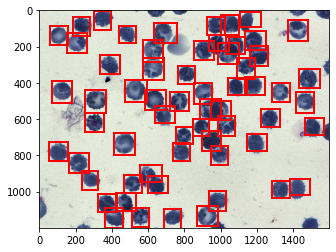

In [17]:
i = 1
cur_path = "/content/drive/Shared drives/EECS545/unzipped_files/malaria/"
img_path = train_data[i]['image']['pathname']
print(os.path.isfile(cur_path + img_path))
img = cv2.imread(cur_path + img_path)

fig, ax = plt.subplots(1)
ax.imshow(img[:,:,::-1])
color_label = ['r', 'b', 'g', 'c', 'm', 'k', 'y']
for anno in train_data[i]['objects']:
  label = anno['category']
  rmin = anno['bounding_box']['minimum']['r']
  cmin = anno['bounding_box']['minimum']['c']
  rmax = anno['bounding_box']['maximum']['r']
  cmax = anno['bounding_box']['maximum']['c']
  w = rmax - rmin
  h = cmax - cmin
  rect = patches.Rectangle((cmin, rmin), w, h,
                            linewidth=2, edgecolor=color_label[0], facecolor='none')
  ax.add_patch(rect)

plt.show()

In [0]:
class_dict = {'red blood cell': 0, 'trophozoite': 1, 'schizont': 2, 'difficult': 3, 'ring': 4, 'leukocyte': 5, 'gametocyte': 6}

In [19]:
X_train = np.load("/content/drive/Shared drives/EECS545/unzipped_files/malaria/X_train.npy")
y_train = np.load("/content/drive/Shared drives/EECS545/unzipped_files/malaria/y_train.npy")
print(X_train.shape)
print(y_train.shape)

(80113, 32, 32, 3)
(80113, 1)


In [20]:
X_test = np.load("/content/drive/Shared drives/EECS545/unzipped_files/malaria/X_test.npy")
y_test = np.load("/content/drive/Shared drives/EECS545/unzipped_files/malaria/y_test.npy")
print(X_test.shape)
print(y_test.shape)

(5922, 32, 32, 3)
(5922, 1)


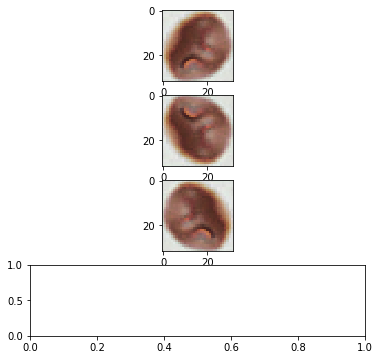

In [21]:
fig = plt.figure(figsize=(6, 6))
num_images = 1
for i in range(num_images):
  idx = np.random.randint(len(X_train), size=1)[0]
  cur_img = X_train[idx]
  fig.add_subplot(4, num_images, i+1)
  plt.imshow(cur_img[:,:,::-1])
  fig.add_subplot(4, num_images, i+2)
  plt.imshow(np.flip(cur_img[:,:,::-1], 0))
  fig.add_subplot(4, num_images, i+3)
  plt.imshow(np.flip(cur_img[:,:,::-1], 1))
  fig.add_subplot(4, num_images, i+4)
#   plt.imshow()
# plt.show()

### **Model**


In [22]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
from __future__ import print_function, division, absolute_import
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.model_zoo as model_zoo
from torch.nn import init
from sklearn.metrics import classification_report, f1_score

PyTorch Version:  1.3.1
Torchvision Version:  0.4.2


In [0]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [0]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [0]:
###data_dir = "./data/hymenoptera_data"

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "resnet"

# Number of classes in the dataset
num_classes = 7

# Batch size for training (change depending on how much memory you have)
batch_size = 8

# Number of epochs to train for
num_epochs = 15

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

In [27]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
print(model_ft)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [0]:
__all__ = ['ResNet', 'resnet18', 'resnet34', 'resnet50', 'resnet101',
           'resnet152', 'resnext50_32x4d', 'resnext101_32x8d',
           'wide_resnet50_2', 'wide_resnet101_2']


model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
    'resnext50_32x4d': 'https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth',
    'resnext101_32x8d': 'https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth',
    'wide_resnet50_2': 'https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth',
    'wide_resnet101_2': 'https://download.pytorch.org/models/wide_resnet101_2-32ee1156.pth',
}


def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion = 1
    __constants__ = ['downsample']

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4
    __constants__ = ['downsample']

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=7, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None,
                 norm_layer=None):
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def _forward_impl(self, x):
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

    def forward(self, x):
        return self._forward_impl(x)


def _resnet(arch, block, layers, pretrained, progress, **kwargs):
    model = ResNet(block, layers, **kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls[arch],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model


def resnet18(pretrained=False, progress=True, **kwargs):
    r"""ResNet-18 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet18', BasicBlock, [2, 2, 2, 2], pretrained, progress,
                   **kwargs)


def resnet34(pretrained=False, progress=True, **kwargs):
    r"""ResNet-34 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet34', BasicBlock, [3, 4, 6, 3], pretrained, progress,
                   **kwargs)


def resnet50(pretrained=False, progress=True, **kwargs):
    r"""ResNet-50 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet50', Bottleneck, [3, 4, 6, 3], pretrained, progress,
                   **kwargs)


def resnet101(pretrained=False, progress=True, **kwargs):
    r"""ResNet-101 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet101', Bottleneck, [3, 4, 23, 3], pretrained, progress,
                   **kwargs)


def resnet152(pretrained=False, progress=True, **kwargs):
    r"""ResNet-152 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet152', Bottleneck, [3, 8, 36, 3], pretrained, progress,
                   **kwargs)


def resnext50_32x4d(pretrained=False, progress=True, **kwargs):
    r"""ResNeXt-50 32x4d model from
    `"Aggregated Residual Transformation for Deep Neural Networks" <https://arxiv.org/pdf/1611.05431.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['groups'] = 32
    kwargs['width_per_group'] = 4
    return _resnet('resnext50_32x4d', Bottleneck, [3, 4, 6, 3],
                   pretrained, progress, **kwargs)


def resnext101_32x8d(pretrained=False, progress=True, **kwargs):
    r"""ResNeXt-101 32x8d model from
    `"Aggregated Residual Transformation for Deep Neural Networks" <https://arxiv.org/pdf/1611.05431.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['groups'] = 32
    kwargs['width_per_group'] = 8
    return _resnet('resnext101_32x8d', Bottleneck, [3, 4, 23, 3],
                   pretrained, progress, **kwargs)


def wide_resnet50_2(pretrained=False, progress=True, **kwargs):
    r"""Wide ResNet-50-2 model from
    `"Wide Residual Networks" <https://arxiv.org/pdf/1605.07146.pdf>`_
    The model is the same as ResNet except for the bottleneck number of channels
    which is twice larger in every block. The number of channels in outer 1x1
    convolutions is the same, e.g. last block in ResNet-50 has 2048-512-2048
    channels, and in Wide ResNet-50-2 has 2048-1024-2048.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['width_per_group'] = 64 * 2
    return _resnet('wide_resnet50_2', Bottleneck, [3, 4, 6, 3],
                   pretrained, progress, **kwargs)


def wide_resnet101_2(pretrained=False, progress=True, **kwargs):
    r"""Wide ResNet-101-2 model from
    `"Wide Residual Networks" <https://arxiv.org/pdf/1605.07146.pdf>`_
    The model is the same as ResNet except for the bottleneck number of channels
    which is twice larger in every block. The number of channels in outer 1x1
    convolutions is the same, e.g. last block in ResNet-50 has 2048-512-2048
    channels, and in Wide ResNet-50-2 has 2048-1024-2048.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['width_per_group'] = 64 * 2
    return _resnet('wide_resnet101_2', Bottleneck, [3, 4, 23, 3],
                   pretrained, progress, **kwargs)

In [29]:
batch_size = 32
validation_ratio = 0.1

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [0]:
def f1_loss(y_true:torch.Tensor, y_pred:torch.Tensor, is_training=False) -> torch.Tensor:
    assert y_true.ndim == 1
    assert y_pred.ndim == 1 or y_pred.ndim == 2
    
    if y_pred.ndim == 2:
        y_pred = y_pred.argmax(dim=1)
        
    
    tp = (y_true * y_pred).sum().to(torch.float32)
    tn = ((1 - y_true) * (1 - y_pred)).sum().to(torch.float32)
    fp = ((1 - y_true) * y_pred).sum().to(torch.float32)
    fn = (y_true * (1 - y_pred)).sum().to(torch.float32)
    
    epsilon = 1e-7
    
    precision = tp / (tp + fp + epsilon)
    recall = tp / (tp + fn + epsilon)
    
    f1 = 2* (precision*recall) / (precision + recall + epsilon)
    f1.requires_grad = is_training
    return f1

In [0]:
class malaria_dataset(Dataset):
  def __init__(self, X, y, transform=None):
    self.images = X
    self.labels = y
    self.transform = transform

  def __getitem__(self, index):
    img = self.images[index]
    label = self.labels[index]

    if self.transform is not None:
      img = self.transform(img)

    return img, label

  def __len__(self):
    return len(self.images)

In [32]:
split_point = int(np.floor(len(X_train) * validation_ratio))
indices = np.arange(len(X_train))
np.random.seed(3)
np.random.shuffle(indices)
train_idx, valid_idx = indices[split_point:], indices[:split_point]

train_img = X_train[train_idx]
train_label = y_train[train_idx]
valid_img = X_train[valid_idx]
valid_label = y_train[valid_idx]
test_img = X_test
test_label = y_test

print("Train dataset")
print(train_img.shape)
print(train_label.shape)
for i in range(7):
  cur_idx = np.argwhere(train_label == i)
  print("{} label: {}".format(i, len(cur_idx)))

print("Valid dataset")
print(valid_img.shape)
print(valid_label.shape)
for i in range(7):
  cur_idx = np.argwhere(valid_label == i)
  print("{} label: {}".format(i, len(cur_idx)))

print("Test dataset")
print(test_img.shape)
print(test_label.shape)
for i in range(7):
  cur_idx = np.argwhere(test_label == i)
  print("{} label: {}".format(i, len(cur_idx)))
# train_img = torch.from_numpy(X_train[split_point:]).float().to(device)
# train_label = torch.from_numpy(y_train[split_point:]).float().to(device)
# valid_img = torch.from_numpy(X_train[:split_point]).float().to(device)
# valid_label = torch.from_numpy(y_train[:split_point]).float().to(device)
# test_img = torch.from_numpy(X_test).float().to(device)
# test_label = torch.from_numpy(y_test).float().to(device)
# print(train_img.size())
# print(train_label.size())
# print(valid_img.size())
# print(valid_label.size())
# print(test_img.size())
# print(test_label.size())
"""transforms.RandomRotation([-90, 90]), transforms.RandomVerticalFlip(),
                                                             transforms.RandomHorizontalFlip(), """
malaria_train = malaria_dataset(train_img, train_label,
                               transform=transforms.Compose([transforms.ToTensor()]))
malaria_valid = malaria_dataset(valid_img, valid_label,
                               transform=transforms.Compose([transforms.ToTensor()]))
malaria_test = malaria_dataset(test_img, test_label,
                               transform=transforms.Compose([transforms.ToTensor()]))

Train dataset
(72102, 32, 32, 3)
(72102, 1)
0 label: 69690
1 label: 1326
2 label: 160
3 label: 397
4 label: 314
5 label: 87
6 label: 128
Valid dataset
(8011, 32, 32, 3)
(8011, 1)
0 label: 7730
1 label: 147
2 label: 19
3 label: 44
4 label: 39
5 label: 16
6 label: 16
Test dataset
(5922, 32, 32, 3)
(5922, 1)
0 label: 5614
1 label: 111
2 label: 11
3 label: 5
4 label: 169
5 label: 0
6 label: 12


### CrossEntropy Loss with SGD Optimizer

In [0]:
initial_lr = 0.001
num_epochs = 10

resnet_model = resnet50()
resnet_model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet_model.parameters(), lr=initial_lr, momentum=0.9)

train_loader = torch.utils.data.DataLoader(
    malaria_train, batch_size=batch_size
)
valid_loader = torch.utils.data.DataLoader(
    malaria_valid, batch_size=batch_size
)
test_loader = torch.utils.data.DataLoader(
    malaria_test, batch_size=batch_size, shuffle=False
)

loss_history = []
train_acc = []
train_f1_score = []
val_acc = []
val_f1_score = []
for epoch in range(num_epochs):
    print("epoch {}".format(epoch+1))

    if epoch == 0:
        lr = initial_lr
    elif epoch % 2 == 0 and epoch != 0:
        lr *= 0.94
        optimizer = optim.SGD(resnet_model.parameters(), lr=lr, momentum=0.9)
    
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        # Data augmentation
        # Horizontal Flip
        if torch.rand(1).item() > 0.5:
          inputs = inputs.flip(2)
        # Vertical Flip
        if torch.rand(1).item() > 0.5:
          inputs = inputs.flip(3)
        # 90 rotation
        if torch.rand(1).item() > 0.5:
          inputs = inputs.transpose(2, 3)
        # or 270 rotation
        elif torch.rand(1).item() > 0.5:
          inputs = inputs.transpose(2, 3).flip(3)
        labels = labels.view(-1)
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = resnet_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        show_period = 250
        if i % show_period == show_period-1:    # print every "show_period" mini-batches
            print('[%d, %5d] loss: %.7f' %
                  (epoch + 1, i + 1, running_loss / show_period))
            loss_history.append(running_loss)
            running_loss = 0.0
        
    #validation part
    correct = 0
    total = 0
    each_correct = np.zeros(7)
    each_total = np.zeros(7)
    total_predicted = None
    total_labels = None
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.view(-1)
        outputs = resnet_model(inputs)
        
        _, predicted = torch.max(outputs.data, 1)
        if total_predicted is None:
          total_predicted = predicted
          total_labels = labels
        else:
          total_predicted = torch.cat((total_predicted, predicted), axis=0)
          total_labels = torch.cat((total_labels, labels), axis=0)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        for i in range(7):
          cur_idx = (labels == i).nonzero()
          cur_label = labels[cur_idx]
          cur_predicted = predicted[cur_idx]
          each_total[i] += cur_label.size(0)
          each_correct[i] += (cur_predicted == cur_label).sum().item()
    print("Training accuracy = {0:.3f}%".format(correct / total * 100))
    for i in range(7):
      print("{} label: Total={}, correct={}, acc={}".format(i,
                                                            each_total[i],
                                                            each_correct[i],
                                                            each_correct[i]/each_total[i]))
    train_acc.append(correct / total * 100)
    f1 = f1_score(total_labels.cpu().numpy(), total_predicted.cpu().numpy(), average="macro")
    print("Training f1 score = {0:.3f}".format(f1))
    train_f1_score.append(f1)

    correct = 0
    total = 0
    each_correct = np.zeros(7)
    each_total = np.zeros(7)
    total_predicted = None
    total_labels = None
    for i, data in enumerate(valid_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.view(-1)
        outputs = resnet_model(inputs)
        
        _, predicted = torch.max(outputs.data, 1)
        if total_predicted is None:
          total_predicted = predicted
          total_labels = labels
        else:
          total_predicted = torch.cat((total_predicted, predicted), axis=0)
          total_labels = torch.cat((total_labels, labels), axis=0)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        for i in range(7):
          cur_idx = (labels == i).nonzero()
          cur_label = labels[cur_idx]
          cur_predicted = predicted[cur_idx]
          each_total[i] += cur_label.size(0)
          each_correct[i] += (cur_predicted == cur_label).sum().item()
    print("Validation accuracy = {0:.3f}%".format(correct / total * 100))
    for i in range(7):
      print("{} label: Total={}, correct={}, acc={}".format(i,
                                                            each_total[i],
                                                            each_correct[i],
                                                            each_correct[i]/each_total[i]))
    val_acc.append(correct / total * 100)
    f1 = f1_score(total_labels.cpu().numpy(), total_predicted.cpu().numpy(), average="macro")
    print("Valid f1 score = {0:.3f}".format(f1))
    val_f1_score.append(f1)

print('Finished Training')

epoch 1
[1,   250] loss: 0.3035579
[1,   500] loss: 0.2351274
[1,   750] loss: 0.2011143
[1,  1000] loss: 0.2041415
[1,  1250] loss: 0.1964962
[1,  1500] loss: 0.1906371
[1,  1750] loss: 0.1990478
[1,  2000] loss: 0.1907205
[1,  2250] loss: 0.1797278
Training accuracy = 96.655%
0 label: Total=69690.0, correct=69679.0, acc=0.9998421581288564
1 label: Total=1326.0, correct=5.0, acc=0.003770739064856712
2 label: Total=160.0, correct=0.0, acc=0.0
3 label: Total=397.0, correct=6.0, acc=0.015113350125944584
4 label: Total=314.0, correct=0.0, acc=0.0
5 label: Total=87.0, correct=0.0, acc=0.0
6 label: Total=128.0, correct=0.0, acc=0.0
Training f1 score = 0.146


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Validation accuracy = 96.480%
0 label: Total=7730.0, correct=7729.0, acc=0.9998706338939198
1 label: Total=147.0, correct=0.0, acc=0.0
2 label: Total=19.0, correct=0.0, acc=0.0
3 label: Total=44.0, correct=0.0, acc=0.0
4 label: Total=39.0, correct=0.0, acc=0.0
5 label: Total=16.0, correct=0.0, acc=0.0
6 label: Total=16.0, correct=0.0, acc=0.0
Valid f1 score = 0.140
epoch 2
[2,   250] loss: 0.1632888
[2,   500] loss: 0.1742617
[2,   750] loss: 0.1422322
[2,  1000] loss: 0.1247998
[2,  1250] loss: 0.1238861
[2,  1500] loss: 0.1113963
[2,  1750] loss: 0.1186106
[2,  2000] loss: 0.1165118
[2,  2250] loss: 0.1040957
Training accuracy = 96.989%
0 label: Total=69690.0, correct=69617.0, acc=0.9989525039460467
1 label: Total=1326.0, correct=95.0, acc=0.07164404223227752
2 label: Total=160.0, correct=0.0, acc=0.0
3 label: Total=397.0, correct=219.0, acc=0.5516372795969773
4 label: Total=314.0, correct=0.0, acc=0.0
5 label: Total=87.0, correct=0.0, acc=0.0
6 label: Total=128.0, correct=0.0, acc=0

In [0]:
# test part
correct = 0
total = 0
each_correct = np.zeros(7)
each_total = np.zeros(7)
total_predicted = None
total_labels = None
for i, data in enumerate(test_loader, 0):
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    labels = labels.view(-1)
    outputs = resnet_model(inputs)
    
    _, predicted = torch.max(outputs.data, 1)
    if total_predicted is None:
      total_predicted = predicted
      total_labels = labels
    else:
      total_predicted = torch.cat((total_predicted, predicted), axis=0)
      total_labels = torch.cat((total_labels, labels), axis=0)

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

    for i in range(7):
      cur_idx = (labels == i).nonzero()
      cur_label = labels[cur_idx]
      cur_predicted = predicted[cur_idx]
      each_total[i] += cur_label.size(0)
      each_correct[i] += (cur_predicted == cur_label).sum().item()
print("Test accuracy = {0:.3f}%".format(correct / total * 100))
for i in range(7):
  print("{} label: Total={}, correct={}, acc={}".format(i,
                                                        each_total[i],
                                                        each_correct[i],
                                                        each_correct[i]/each_total[i]))
f1 = f1_score(total_labels.cpu().numpy(), total_predicted.cpu().numpy(), average="macro")
print("Test f1 score = {0:.3f}".format(f1))

Test accuracy = 95.120%
0 label: Total=5614.0, correct=5612.0, acc=0.9996437477734236
1 label: Total=111.0, correct=15.0, acc=0.13513513513513514
2 label: Total=11.0, correct=2.0, acc=0.18181818181818182
3 label: Total=5.0, correct=0.0, acc=0.0
4 label: Total=169.0, correct=4.0, acc=0.023668639053254437
5 label: Total=0.0, correct=0.0, acc=nan
6 label: Total=12.0, correct=0.0, acc=0.0
Test f1 score = 0.215


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Text(0.5, 0, 'Epochs')

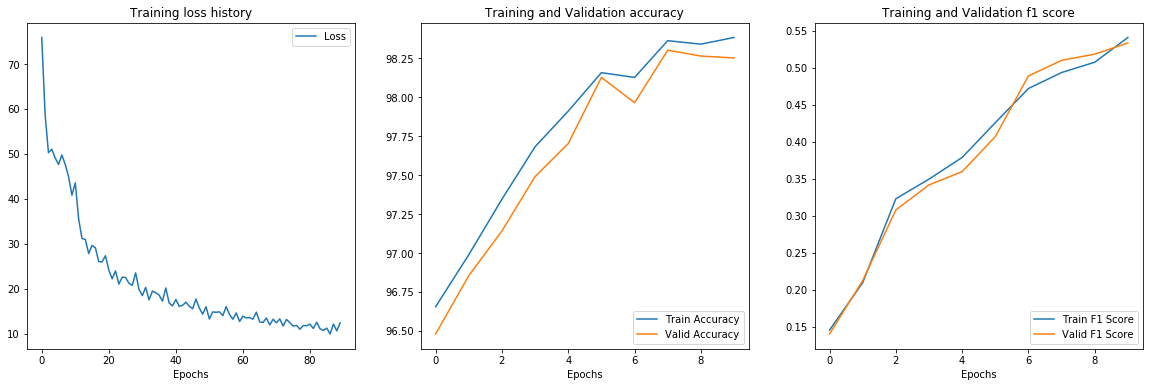

In [0]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))
axs[0].plot(loss_history, label='Loss')
axs[0].title.set_text("Training loss history")
axs[0].legend(loc="upper right")
axs[0].set_xlabel("Epochs")
axs[1].plot(train_acc, label='Train Accuracy')
axs[1].plot(val_acc, label='Valid Accuracy')
axs[1].title.set_text("Training and Validation accuracy")
axs[1].legend(loc="lower right")
axs[1].set_xlabel("Epochs")
axs[2].plot(train_f1_score, label='Train F1 Score')
axs[2].plot(val_f1_score, label='Valid F1 Score')
axs[2].title.set_text("Training and Validation f1 score")
axs[2].legend(loc="lower right")
axs[2].set_xlabel("Epochs")

### Cross Entropy with Adam

In [0]:
initial_lr = 0.0001
num_epochs = 10

resnet_model = resnet50()
resnet_model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet_model.parameters(), lr=initial_lr)

train_loader = torch.utils.data.DataLoader(
    malaria_train, batch_size=batch_size
)
valid_loader = torch.utils.data.DataLoader(
    malaria_valid, batch_size=batch_size
)
test_loader = torch.utils.data.DataLoader(
    malaria_test, batch_size=batch_size, shuffle=False
)

loss_history = []
train_acc = []
train_f1_score = []
val_acc = []
val_f1_score = []
for epoch in range(num_epochs):
    print("epoch {}".format(epoch+1))

    if epoch == 0:
        lr = initial_lr
    elif epoch % 2 == 0 and epoch != 0:
        lr *= 0.94
        optimizer = optim.Adam(resnet_model.parameters(), lr=lr)
    
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        # Data augmentation
        # Horizontal Flip
        if torch.rand(1).item() > 0.5:
          inputs = inputs.flip(2)
        # Vertical Flip
        if torch.rand(1).item() > 0.5:
          inputs = inputs.flip(3)
        # 90 rotation
        if torch.rand(1).item() > 0.5:
          inputs = inputs.transpose(2, 3)
        # or 270 rotation
        elif torch.rand(1).item() > 0.5:
          inputs = inputs.transpose(2, 3).flip(3)
        labels = labels.view(-1)
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = resnet_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        show_period = 250
        if i % show_period == show_period-1:    # print every "show_period" mini-batches
            print('[%d, %5d] loss: %.7f' %
                  (epoch + 1, i + 1, running_loss / show_period))
            loss_history.append(running_loss)
            running_loss = 0.0
        
    #validation part
    correct = 0
    total = 0
    each_correct = np.zeros(7)
    each_total = np.zeros(7)
    total_predicted = None
    total_labels = None
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.view(-1)
        outputs = resnet_model(inputs)
        
        _, predicted = torch.max(outputs.data, 1)
        if total_predicted is None:
          total_predicted = predicted
          total_labels = labels
        else:
          total_predicted = torch.cat((total_predicted, predicted), axis=0)
          total_labels = torch.cat((total_labels, labels), axis=0)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        for i in range(7):
          cur_idx = (labels == i).nonzero()
          cur_label = labels[cur_idx]
          cur_predicted = predicted[cur_idx]
          each_total[i] += cur_label.size(0)
          each_correct[i] += (cur_predicted == cur_label).sum().item()
    print("Training accuracy = {0:.3f}%".format(correct / total * 100))
    for i in range(7):
      print("{} label: Total={}, correct={}, acc={}".format(i,
                                                            each_total[i],
                                                            each_correct[i],
                                                            each_correct[i]/each_total[i]))
    train_acc.append(correct / total * 100)
    f1 = f1_score(total_labels.cpu().numpy(), total_predicted.cpu().numpy(), average="macro")
    print("Training f1 score = {0:.3f}".format(f1))
    train_f1_score.append(f1)

    correct = 0
    total = 0
    each_correct = np.zeros(7)
    each_total = np.zeros(7)
    total_predicted = None
    total_labels = None
    for i, data in enumerate(valid_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.view(-1)
        outputs = resnet_model(inputs)
        
        _, predicted = torch.max(outputs.data, 1)
        if total_predicted is None:
          total_predicted = predicted
          total_labels = labels
        else:
          total_predicted = torch.cat((total_predicted, predicted), axis=0)
          total_labels = torch.cat((total_labels, labels), axis=0)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        for i in range(7):
          cur_idx = (labels == i).nonzero()
          cur_label = labels[cur_idx]
          cur_predicted = predicted[cur_idx]
          each_total[i] += cur_label.size(0)
          each_correct[i] += (cur_predicted == cur_label).sum().item()
    print("Validation accuracy = {0:.3f}%".format(correct / total * 100))
    for i in range(7):
      print("{} label: Total={}, correct={}, acc={}".format(i,
                                                            each_total[i],
                                                            each_correct[i],
                                                            each_correct[i]/each_total[i]))
    val_acc.append(correct / total * 100)
    f1 = f1_score(total_labels.cpu().numpy(), total_predicted.cpu().numpy(), average="macro")
    print("Valid f1 score = {0:.3f}".format(f1))
    val_f1_score.append(f1)

print('Finished Training')

epoch 1
[1,   250] loss: 0.2567037
[1,   500] loss: 0.2174871
[1,   750] loss: 0.1747473
[1,  1000] loss: 0.1640772
[1,  1250] loss: 0.1517843
[1,  1500] loss: 0.1200435
[1,  1750] loss: 0.1331809
[1,  2000] loss: 0.1230727
[1,  2250] loss: 0.1122112
Training accuracy = 96.896%
0 label: Total=69690.0, correct=69571.0, acc=0.9982924379394461
1 label: Total=1326.0, correct=31.0, acc=0.023378582202111614
2 label: Total=160.0, correct=5.0, acc=0.03125
3 label: Total=397.0, correct=239.0, acc=0.6020151133501259
4 label: Total=314.0, correct=1.0, acc=0.0031847133757961785
5 label: Total=87.0, correct=17.0, acc=0.19540229885057472
6 label: Total=128.0, correct=0.0, acc=0.0
Training f1 score = 0.245


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Validation accuracy = 96.729%
0 label: Total=7730.0, correct=7719.0, acc=0.9985769728331177
1 label: Total=147.0, correct=3.0, acc=0.02040816326530612
2 label: Total=19.0, correct=0.0, acc=0.0
3 label: Total=44.0, correct=24.0, acc=0.5454545454545454
4 label: Total=39.0, correct=0.0, acc=0.0
5 label: Total=16.0, correct=3.0, acc=0.1875
6 label: Total=16.0, correct=0.0, acc=0.0
Valid f1 score = 0.235
epoch 2
[2,   250] loss: 0.1007118
[2,   500] loss: 0.1138420
[2,   750] loss: 0.0947249
[2,  1000] loss: 0.0800924
[2,  1250] loss: 0.0906042
[2,  1500] loss: 0.0747777
[2,  1750] loss: 0.0783215
[2,  2000] loss: 0.0806398
[2,  2250] loss: 0.0764560
Training accuracy = 97.441%
0 label: Total=69690.0, correct=69658.0, acc=0.9995408236475821
1 label: Total=1326.0, correct=334.0, acc=0.25188536953242835
2 label: Total=160.0, correct=1.0, acc=0.00625
3 label: Total=397.0, correct=232.0, acc=0.5843828715365239
4 label: Total=314.0, correct=18.0, acc=0.05732484076433121
5 label: Total=87.0, corr

In [0]:
# test part
correct = 0
total = 0
each_correct = np.zeros(7)
each_total = np.zeros(7)
total_predicted = None
total_labels = None
for i, data in enumerate(test_loader, 0):
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    labels = labels.view(-1)
    outputs = resnet_model(inputs)
    
    _, predicted = torch.max(outputs.data, 1)
    if total_predicted is None:
      total_predicted = predicted
      total_labels = labels
    else:
      total_predicted = torch.cat((total_predicted, predicted), axis=0)
      total_labels = torch.cat((total_labels, labels), axis=0)

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

    for i in range(7):
      cur_idx = (labels == i).nonzero()
      cur_label = labels[cur_idx]
      cur_predicted = predicted[cur_idx]
      each_total[i] += cur_label.size(0)
      each_correct[i] += (cur_predicted == cur_label).sum().item()
print("Test accuracy = {0:.3f}%".format(correct / total * 100))
for i in range(7):
  print("{} label: Total={}, correct={}, acc={}".format(i,
                                                        each_total[i],
                                                        each_correct[i],
                                                        each_correct[i]/each_total[i]))
f1 = f1_score(total_labels.cpu().numpy(), total_predicted.cpu().numpy(), average="macro")
print("Test f1 score = {0:.3f}".format(f1))

Test accuracy = 96.116%
0 label: Total=5614.0, correct=5590.0, acc=0.995724973281083
1 label: Total=111.0, correct=84.0, acc=0.7567567567567568
2 label: Total=11.0, correct=5.0, acc=0.45454545454545453
3 label: Total=5.0, correct=0.0, acc=0.0
4 label: Total=169.0, correct=13.0, acc=0.07692307692307693
5 label: Total=0.0, correct=0.0, acc=nan
6 label: Total=12.0, correct=0.0, acc=0.0
Test f1 score = 0.289


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Text(0.5, 0, 'Epochs')

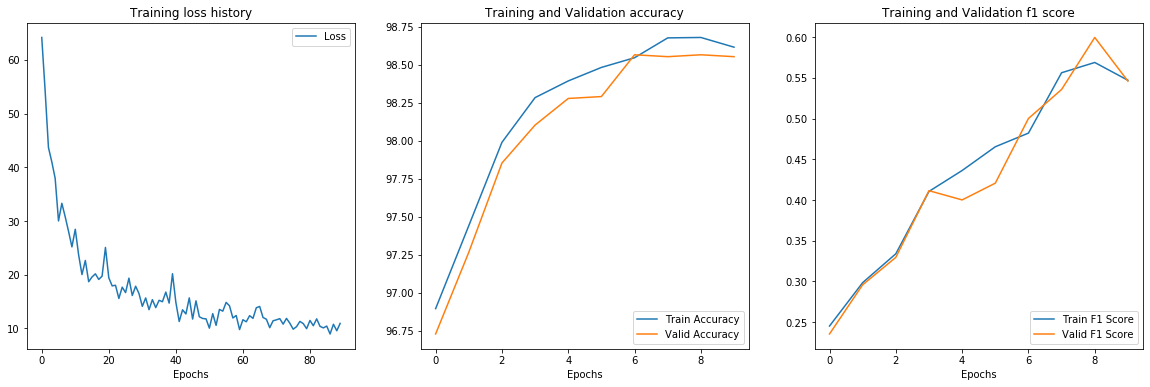

In [0]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))
axs[0].plot(loss_history, label='Loss')
axs[0].title.set_text("Training loss history")
axs[0].legend(loc="upper right")
axs[0].set_xlabel("Epochs")
axs[1].plot(train_acc, label='Train Accuracy')
axs[1].plot(val_acc, label='Valid Accuracy')
axs[1].title.set_text("Training and Validation accuracy")
axs[1].legend(loc="lower right")
axs[1].set_xlabel("Epochs")
axs[2].plot(train_f1_score, label='Train F1 Score')
axs[2].plot(val_f1_score, label='Valid F1 Score')
axs[2].title.set_text("Training and Validation f1 score")
axs[2].legend(loc="lower right")
axs[2].set_xlabel("Epochs")

### Focal Loss with Adam Optimizer

In [0]:
def one_hot_embedding(labels, num_classes):
    '''Embedding labels to one-hot form.
    Args:
      labels: (LongTensor) class labels, sized [N,].
      num_classes: (int) number of classes.
    Returns:
      (tensor) encoded labels, sized [N,#classes].
    '''
    y = torch.eye(num_classes)  # [D,D]
    return y[labels]            # [N,D]


class FocalLoss(nn.Module):
    def __init__(self, num_classes=7):
        super(FocalLoss, self).__init__()
        self.num_classes = num_classes

    def focal_loss(self, x, y):
        '''Focal loss.
        Args:
          x: (tensor) sized [N,D].
          y: (tensor) sized [N,].
        Return:
          (tensor) focal loss.
        '''
        alpha = 0.25
        gamma = 2

        t = one_hot_embedding(y.data.cpu(), 1+self.num_classes)  # [N,21]
        t = t[:,1:]  # exclude background
        t = Variable(t).cuda()  # [N,20]

        p = x.sigmoid()
        pt = p*t + (1-p)*(1-t)         # pt = p if t > 0 else 1-p
        w = alpha*t + (1-alpha)*(1-t)  # w = alpha if t > 0 else 1-alpha
        w = w * (1-pt).pow(gamma)
        return F.binary_cross_entropy_with_logits(x, t, w, size_average=False)

    def focal_loss_alt(self, x, y):
        '''Focal loss alternative.
        Args:
          x: (tensor) sized [N,D].
          y: (tensor) sized [N,].
        Return:
          (tensor) focal loss.
        '''
        alpha = 0.25
        eps = 1e-8

        t = one_hot_embedding(y.data.cpu(), self.num_classes)
        t = Variable(t).cuda()

        xt = x*(2*t-1)  # xt = x if t > 0 else -x
        pt = (2*xt+1).sigmoid()

        w = alpha*t + (1-alpha)*(1-t)
        loss = -w*pt.log() / 2
        return loss.sum()

    def forward(self, outputs, labels):
        loss = self.focal_loss_alt(outputs, labels)
        return loss

In [0]:
initial_lr = 0.0001
num_epochs = 10

resnet_model = resnet50()
resnet_model.to(device)
criterion = FocalLoss(num_classes=7)
optimizer = optim.Adam(resnet_model.parameters(), lr=initial_lr)

train_loader = torch.utils.data.DataLoader(
    malaria_train, batch_size=batch_size
)
valid_loader = torch.utils.data.DataLoader(
    malaria_valid, batch_size=batch_size
)
test_loader = torch.utils.data.DataLoader(
    malaria_test, batch_size=batch_size, shuffle=False
)

loss_history = []
train_acc = []
train_f1_score = []
val_acc = []
val_f1_score = []
for epoch in range(num_epochs):
    print("epoch {}".format(epoch+1))

    if epoch == 0:
        lr = initial_lr
    elif epoch % 2 == 0 and epoch != 0:
        lr *= 0.94
        optimizer = optim.Adam(resnet_model.parameters(), lr=lr)
    
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        # Data augmentation
        # Horizontal Flip
        if torch.rand(1).item() > 0.5:
          inputs = inputs.flip(2)
        # Vertical Flip
        if torch.rand(1).item() > 0.5:
          inputs = inputs.flip(3)
        # 90 rotation
        if torch.rand(1).item() > 0.5:
          inputs = inputs.transpose(2, 3)
        # or 270 rotation
        elif torch.rand(1).item() > 0.5:
          inputs = inputs.transpose(2, 3).flip(3)
        labels = labels.view(-1)
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = resnet_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        show_period = 250
        if i % show_period == show_period-1:    # print every "show_period" mini-batches
            print('[%d, %5d] loss: %.7f' %
                  (epoch + 1, i + 1, running_loss / show_period))
            loss_history.append(running_loss)
            running_loss = 0.0
        
    #validation part
    correct = 0
    total = 0
    each_correct = np.zeros(7)
    each_total = np.zeros(7)
    total_predicted = None
    total_labels = None
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.view(-1)
        outputs = resnet_model(inputs)
        
        _, predicted = torch.max(outputs.data, 1)
        if total_predicted is None:
          total_predicted = predicted
          total_labels = labels
        else:
          total_predicted = torch.cat((total_predicted, predicted), axis=0)
          total_labels = torch.cat((total_labels, labels), axis=0)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        for i in range(7):
          cur_idx = (labels == i).nonzero()
          cur_label = labels[cur_idx]
          cur_predicted = predicted[cur_idx]
          each_total[i] += cur_label.size(0)
          each_correct[i] += (cur_predicted == cur_label).sum().item()
    print("Training accuracy = {0:.3f}%".format(correct / total * 100))
    for i in range(7):
      print("{} label: Total={}, correct={}, acc={}".format(i,
                                                            each_total[i],
                                                            each_correct[i],
                                                            each_correct[i]/each_total[i]))
    train_acc.append(correct / total * 100)
    f1 = f1_score(total_labels.cpu().numpy(), total_predicted.cpu().numpy(), average="macro")
    print("Training f1 score = {0:.3f}".format(f1))
    train_f1_score.append(f1)

    correct = 0
    total = 0
    each_correct = np.zeros(7)
    each_total = np.zeros(7)
    total_predicted = None
    total_labels = None
    for i, data in enumerate(valid_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.view(-1)
        outputs = resnet_model(inputs)
        
        _, predicted = torch.max(outputs.data, 1)
        if total_predicted is None:
          total_predicted = predicted
          total_labels = labels
        else:
          total_predicted = torch.cat((total_predicted, predicted), axis=0)
          total_labels = torch.cat((total_labels, labels), axis=0)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        for i in range(7):
          cur_idx = (labels == i).nonzero()
          cur_label = labels[cur_idx]
          cur_predicted = predicted[cur_idx]
          each_total[i] += cur_label.size(0)
          each_correct[i] += (cur_predicted == cur_label).sum().item()
    print("Validation accuracy = {0:.3f}%".format(correct / total * 100))
    for i in range(7):
      print("{} label: Total={}, correct={}, acc={}".format(i,
                                                            each_total[i],
                                                            each_correct[i],
                                                            each_correct[i]/each_total[i]))
    val_acc.append(correct / total * 100)
    f1 = f1_score(total_labels.cpu().numpy(), total_predicted.cpu().numpy(), average="macro")
    print("Valid f1 score = {0:.3f}".format(f1))
    val_f1_score.append(f1)

print('Finished Training')

epoch 1
[1,   250] loss: 2.0566127
[1,   500] loss: 1.7265200
[1,   750] loss: 1.4408521
[1,  1000] loss: 1.2131830
[1,  1250] loss: 1.1240422
[1,  1500] loss: 1.0346858
[1,  1750] loss: 1.0032537
[1,  2000] loss: 0.9764108
[1,  2250] loss: 0.9096228
Training accuracy = 96.766%
0 label: Total=69690.0, correct=69628.0, acc=0.9991103458171904
1 label: Total=1326.0, correct=8.0, acc=0.006033182503770739
2 label: Total=160.0, correct=3.0, acc=0.01875
3 label: Total=397.0, correct=125.0, acc=0.3148614609571788
4 label: Total=314.0, correct=0.0, acc=0.0
5 label: Total=87.0, correct=6.0, acc=0.06896551724137931
6 label: Total=128.0, correct=0.0, acc=0.0
Training f1 score = 0.204


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Validation accuracy = 96.667%
0 label: Total=7730.0, correct=7723.0, acc=0.9990944372574385
1 label: Total=147.0, correct=1.0, acc=0.006802721088435374
2 label: Total=19.0, correct=0.0, acc=0.0
3 label: Total=44.0, correct=19.0, acc=0.4318181818181818
4 label: Total=39.0, correct=0.0, acc=0.0
5 label: Total=16.0, correct=1.0, acc=0.0625
6 label: Total=16.0, correct=0.0, acc=0.0
Valid f1 score = 0.208
epoch 2
[2,   250] loss: 0.8368688
[2,   500] loss: 0.8676093
[2,   750] loss: 0.8439079
[2,  1000] loss: 0.7000798
[2,  1250] loss: 0.7038110
[2,  1500] loss: 0.6101329
[2,  1750] loss: 0.6717045
[2,  2000] loss: 0.6282419
[2,  2250] loss: 0.5912051
Training accuracy = 97.142%
0 label: Total=69690.0, correct=69603.0, acc=0.998751614291864
1 label: Total=1326.0, correct=155.0, acc=0.11689291101055807
2 label: Total=160.0, correct=0.0, acc=0.0
3 label: Total=397.0, correct=269.0, acc=0.6775818639798489
4 label: Total=314.0, correct=0.0, acc=0.0
5 label: Total=87.0, correct=14.0, acc=0.16091

In [0]:
# test part
correct = 0
total = 0
each_correct = np.zeros(7)
each_total = np.zeros(7)
total_predicted = None
total_labels = None
for i, data in enumerate(test_loader, 0):
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    labels = labels.view(-1)
    outputs = resnet_model(inputs)
    
    _, predicted = torch.max(outputs.data, 1)
    if total_predicted is None:
      total_predicted = predicted
      total_labels = labels
    else:
      total_predicted = torch.cat((total_predicted, predicted), axis=0)
      total_labels = torch.cat((total_labels, labels), axis=0)

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

    for i in range(7):
      cur_idx = (labels == i).nonzero()
      cur_label = labels[cur_idx]
      cur_predicted = predicted[cur_idx]
      each_total[i] += cur_label.size(0)
      each_correct[i] += (cur_predicted == cur_label).sum().item()
print("Test accuracy = {0:.3f}%".format(correct / total * 100))
for i in range(7):
  print("{} label: Total={}, correct={}, acc={}".format(i,
                                                        each_total[i],
                                                        each_correct[i],
                                                        each_correct[i]/each_total[i]))
f1 = f1_score(total_labels.cpu().numpy(), total_predicted.cpu().numpy(), average="macro")
print("Test f1 score = {0:.3f}".format(f1))

Test accuracy = 94.799%
0 label: Total=5614.0, correct=5614.0, acc=1.0
1 label: Total=111.0, correct=0.0, acc=0.0
2 label: Total=11.0, correct=0.0, acc=0.0
3 label: Total=5.0, correct=0.0, acc=0.0
4 label: Total=169.0, correct=0.0, acc=0.0
5 label: Total=0.0, correct=0.0, acc=nan
6 label: Total=12.0, correct=0.0, acc=0.0
Test f1 score = 0.162


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Text(0.5, 0, 'Epochs')

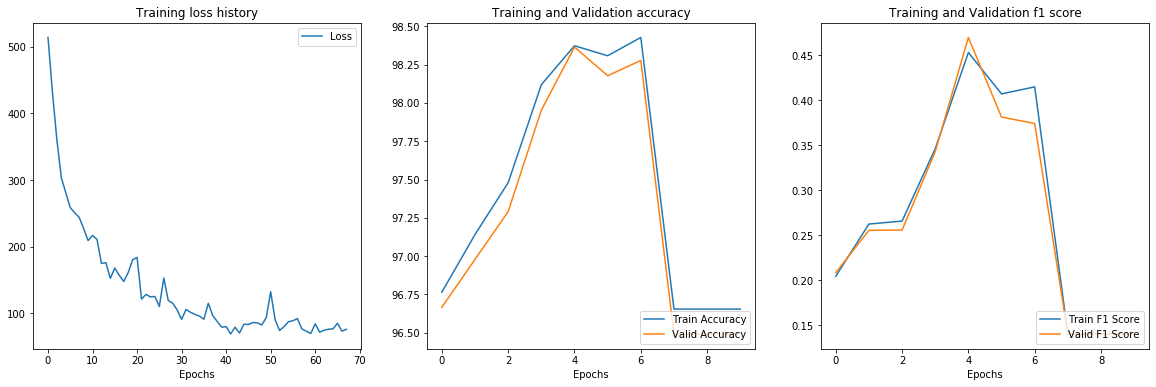

In [0]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))
axs[0].plot(loss_history, label='Loss')
axs[0].title.set_text("Training loss history")
axs[0].legend(loc="upper right")
axs[0].set_xlabel("Epochs")
axs[1].plot(train_acc, label='Train Accuracy')
axs[1].plot(val_acc, label='Valid Accuracy')
axs[1].title.set_text("Training and Validation accuracy")
axs[1].legend(loc="lower right")
axs[1].set_xlabel("Epochs")
axs[2].plot(train_f1_score, label='Train F1 Score')
axs[2].plot(val_f1_score, label='Valid F1 Score')
axs[2].title.set_text("Training and Validation f1 score")
axs[2].legend(loc="lower right")
axs[2].set_xlabel("Epochs")

### Best Model with 1e-6 Learning Rate

In [0]:
initial_lr = 1e-6
num_epochs = 10

resnet_model = resnet50()
resnet_model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet_model.parameters(), lr=initial_lr)

train_loader = torch.utils.data.DataLoader(
    malaria_train, batch_size=batch_size
)
valid_loader = torch.utils.data.DataLoader(
    malaria_valid, batch_size=batch_size
)
test_loader = torch.utils.data.DataLoader(
    malaria_test, batch_size=batch_size, shuffle=False
)

loss_history = []
train_acc = []
train_f1_score = []
val_acc = []
val_f1_score = []
for epoch in range(num_epochs):
    print("epoch {}".format(epoch+1))

    if epoch == 0:
        lr = initial_lr
    elif epoch % 2 == 0 and epoch != 0:
        lr *= 0.94
        optimizer = optim.Adam(resnet_model.parameters(), lr=lr)
    
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        # Data augmentation
        # Horizontal Flip
        if torch.rand(1).item() > 0.5:
          inputs = inputs.flip(2)
        # Vertical Flip
        if torch.rand(1).item() > 0.5:
          inputs = inputs.flip(3)
        # 90 rotation
        if torch.rand(1).item() > 0.5:
          inputs = inputs.transpose(2, 3)
        # or 270 rotation
        elif torch.rand(1).item() > 0.5:
          inputs = inputs.transpose(2, 3).flip(3)
        labels = labels.view(-1)
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = resnet_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        show_period = 250
        if i % show_period == show_period-1:    # print every "show_period" mini-batches
            print('[%d, %5d] loss: %.7f' %
                  (epoch + 1, i + 1, running_loss / show_period))
            loss_history.append(running_loss)
            running_loss = 0.0
        
    #validation part
    correct = 0
    total = 0
    each_correct = np.zeros(7)
    each_total = np.zeros(7)
    total_predicted = None
    total_labels = None
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.view(-1)
        outputs = resnet_model(inputs)
        
        _, predicted = torch.max(outputs.data, 1)
        if total_predicted is None:
          total_predicted = predicted
          total_labels = labels
        else:
          total_predicted = torch.cat((total_predicted, predicted), axis=0)
          total_labels = torch.cat((total_labels, labels), axis=0)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        for i in range(7):
          cur_idx = (labels == i).nonzero()
          cur_label = labels[cur_idx]
          cur_predicted = predicted[cur_idx]
          each_total[i] += cur_label.size(0)
          each_correct[i] += (cur_predicted == cur_label).sum().item()
    print("Training accuracy = {0:.3f}%".format(correct / total * 100))
    for i in range(7):
      print("{} label: Total={}, correct={}, acc={}".format(i,
                                                            each_total[i],
                                                            each_correct[i],
                                                            each_correct[i]/each_total[i]))
    train_acc.append(correct / total * 100)
    f1 = f1_score(total_labels.cpu().numpy(), total_predicted.cpu().numpy(), average="macro")
    print("Training f1 score = {0:.3f}".format(f1))
    train_f1_score.append(f1)

    correct = 0
    total = 0
    each_correct = np.zeros(7)
    each_total = np.zeros(7)
    total_predicted = None
    total_labels = None
    for i, data in enumerate(valid_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.view(-1)
        outputs = resnet_model(inputs)
        
        _, predicted = torch.max(outputs.data, 1)
        if total_predicted is None:
          total_predicted = predicted
          total_labels = labels
        else:
          total_predicted = torch.cat((total_predicted, predicted), axis=0)
          total_labels = torch.cat((total_labels, labels), axis=0)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        for i in range(7):
          cur_idx = (labels == i).nonzero()
          cur_label = labels[cur_idx]
          cur_predicted = predicted[cur_idx]
          each_total[i] += cur_label.size(0)
          each_correct[i] += (cur_predicted == cur_label).sum().item()
    print("Validation accuracy = {0:.3f}%".format(correct / total * 100))
    for i in range(7):
      print("{} label: Total={}, correct={}, acc={}".format(i,
                                                            each_total[i],
                                                            each_correct[i],
                                                            each_correct[i]/each_total[i]))
    val_acc.append(correct / total * 100)
    f1 = f1_score(total_labels.cpu().numpy(), total_predicted.cpu().numpy(), average="macro")
    print("Valid f1 score = {0:.3f}".format(f1))
    val_f1_score.append(f1)

print('Finished Training')

epoch 1
[1,   250] loss: 2.2613335
[1,   500] loss: 1.4723387
[1,   750] loss: 0.9230479
[1,  1000] loss: 0.6130694
[1,  1250] loss: 0.4383130
[1,  1500] loss: 0.3392099
[1,  1750] loss: 0.2941837
[1,  2000] loss: 0.2657021
[1,  2250] loss: 0.2279540
Training accuracy = 96.653%
0 label: Total=69690.0, correct=69689.0, acc=0.9999856507389869
1 label: Total=1326.0, correct=0.0, acc=0.0
2 label: Total=160.0, correct=0.0, acc=0.0
3 label: Total=397.0, correct=0.0, acc=0.0
4 label: Total=314.0, correct=0.0, acc=0.0
5 label: Total=87.0, correct=0.0, acc=0.0
6 label: Total=128.0, correct=0.0, acc=0.0
Training f1 score = 0.140


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Validation accuracy = 96.492%
0 label: Total=7730.0, correct=7730.0, acc=1.0
1 label: Total=147.0, correct=0.0, acc=0.0
2 label: Total=19.0, correct=0.0, acc=0.0
3 label: Total=44.0, correct=0.0, acc=0.0
4 label: Total=39.0, correct=0.0, acc=0.0
5 label: Total=16.0, correct=0.0, acc=0.0
6 label: Total=16.0, correct=0.0, acc=0.0
Valid f1 score = 0.140
epoch 2
[2,   250] loss: 0.2193733
[2,   500] loss: 0.2338905
[2,   750] loss: 0.2112936
[2,  1000] loss: 0.2131902
[2,  1250] loss: 0.2012393
[2,  1500] loss: 0.1915926
[2,  1750] loss: 0.2042399
[2,  2000] loss: 0.2034675
[2,  2250] loss: 0.1852492
Training accuracy = 96.655%
0 label: Total=69690.0, correct=69690.0, acc=1.0
1 label: Total=1326.0, correct=0.0, acc=0.0
2 label: Total=160.0, correct=0.0, acc=0.0
3 label: Total=397.0, correct=0.0, acc=0.0
4 label: Total=314.0, correct=0.0, acc=0.0
5 label: Total=87.0, correct=0.0, acc=0.0
6 label: Total=128.0, correct=0.0, acc=0.0
Training f1 score = 0.140
Validation accuracy = 96.492%
0 lab

In [0]:
# test part
correct = 0
total = 0
each_correct = np.zeros(7)
each_total = np.zeros(7)
total_predicted = None
total_labels = None
for i, data in enumerate(test_loader, 0):
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    labels = labels.view(-1)
    outputs = resnet_model(inputs)
    
    _, predicted = torch.max(outputs.data, 1)
    if total_predicted is None:
      total_predicted = predicted
      total_labels = labels
    else:
      total_predicted = torch.cat((total_predicted, predicted), axis=0)
      total_labels = torch.cat((total_labels, labels), axis=0)

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

    for i in range(7):
      cur_idx = (labels == i).nonzero()
      cur_label = labels[cur_idx]
      cur_predicted = predicted[cur_idx]
      each_total[i] += cur_label.size(0)
      each_correct[i] += (cur_predicted == cur_label).sum().item()
print("Test accuracy = {0:.3f}%".format(correct / total * 100))
for i in range(7):
  print("{} label: Total={}, correct={}, acc={}".format(i,
                                                        each_total[i],
                                                        each_correct[i],
                                                        each_correct[i]/each_total[i]))
f1 = f1_score(total_labels.cpu().numpy(), total_predicted.cpu().numpy(), average="macro")
print("Test f1 score = {0:.3f}".format(f1))

Test accuracy = 94.799%
0 label: Total=5614.0, correct=5613.0, acc=0.9998218738867118
1 label: Total=111.0, correct=0.0, acc=0.0
2 label: Total=11.0, correct=1.0, acc=0.09090909090909091
3 label: Total=5.0, correct=0.0, acc=0.0
4 label: Total=169.0, correct=0.0, acc=0.0
5 label: Total=0.0, correct=0.0, acc=nan
6 label: Total=12.0, correct=0.0, acc=0.0
Test f1 score = 0.163


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Text(0.5, 0, 'Epochs')

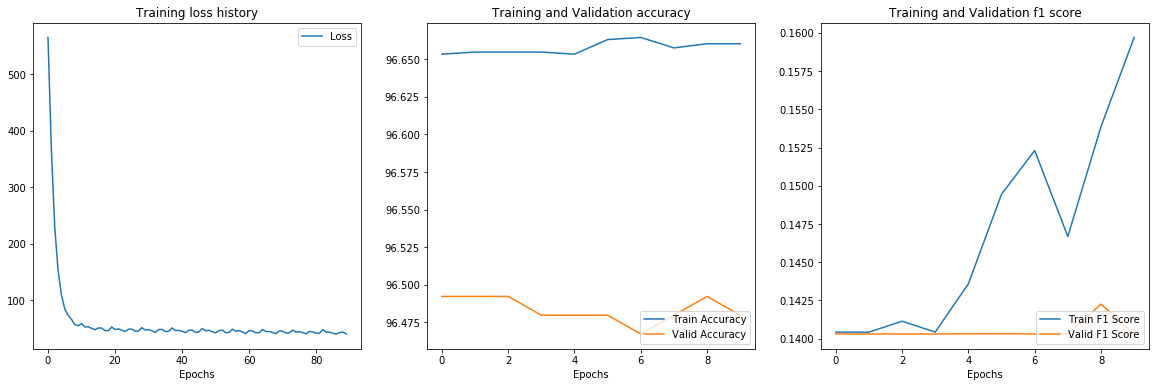

In [0]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))
axs[0].plot(loss_history, label='Loss')
axs[0].title.set_text("Training loss history")
axs[0].legend(loc="upper right")
axs[0].set_xlabel("Epochs")
axs[1].plot(train_acc, label='Train Accuracy')
axs[1].plot(val_acc, label='Valid Accuracy')
axs[1].title.set_text("Training and Validation accuracy")
axs[1].legend(loc="lower right")
axs[1].set_xlabel("Epochs")
axs[2].plot(train_f1_score, label='Train F1 Score')
axs[2].plot(val_f1_score, label='Valid F1 Score')
axs[2].title.set_text("Training and Validation f1 score")
axs[2].legend(loc="lower right")
axs[2].set_xlabel("Epochs")

### Best Model with 0.1 Learning Rate

In [0]:
initial_lr = 0.1
num_epochs = 10

resnet_model = resnet50()
resnet_model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet_model.parameters(), lr=initial_lr)

train_loader = torch.utils.data.DataLoader(
    malaria_train, batch_size=batch_size
)
valid_loader = torch.utils.data.DataLoader(
    malaria_valid, batch_size=batch_size
)
test_loader = torch.utils.data.DataLoader(
    malaria_test, batch_size=batch_size, shuffle=False
)

loss_history = []
train_acc = []
train_f1_score = []
val_acc = []
val_f1_score = []
for epoch in range(num_epochs):
    print("epoch {}".format(epoch+1))

    if epoch == 0:
        lr = initial_lr
    elif epoch % 2 == 0 and epoch != 0:
        lr *= 0.94
        optimizer = optim.Adam(resnet_model.parameters(), lr=lr)
    
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        # Data augmentation
        # Horizontal Flip
        if torch.rand(1).item() > 0.5:
          inputs = inputs.flip(2)
        # Vertical Flip
        if torch.rand(1).item() > 0.5:
          inputs = inputs.flip(3)
        # 90 rotation
        if torch.rand(1).item() > 0.5:
          inputs = inputs.transpose(2, 3)
        # or 270 rotation
        elif torch.rand(1).item() > 0.5:
          inputs = inputs.transpose(2, 3).flip(3)
        labels = labels.view(-1)
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = resnet_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        show_period = 250
        if i % show_period == show_period-1:    # print every "show_period" mini-batches
            print('[%d, %5d] loss: %.7f' %
                  (epoch + 1, i + 1, running_loss / show_period))
            loss_history.append(running_loss)
            running_loss = 0.0
        
    #validation part
    correct = 0
    total = 0
    each_correct = np.zeros(7)
    each_total = np.zeros(7)
    total_predicted = None
    total_labels = None
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.view(-1)
        outputs = resnet_model(inputs)
        
        _, predicted = torch.max(outputs.data, 1)
        if total_predicted is None:
          total_predicted = predicted
          total_labels = labels
        else:
          total_predicted = torch.cat((total_predicted, predicted), axis=0)
          total_labels = torch.cat((total_labels, labels), axis=0)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        for i in range(7):
          cur_idx = (labels == i).nonzero()
          cur_label = labels[cur_idx]
          cur_predicted = predicted[cur_idx]
          each_total[i] += cur_label.size(0)
          each_correct[i] += (cur_predicted == cur_label).sum().item()
    print("Training accuracy = {0:.3f}%".format(correct / total * 100))
    for i in range(7):
      print("{} label: Total={}, correct={}, acc={}".format(i,
                                                            each_total[i],
                                                            each_correct[i],
                                                            each_correct[i]/each_total[i]))
    train_acc.append(correct / total * 100)
    f1 = f1_score(total_labels.cpu().numpy(), total_predicted.cpu().numpy(), average="macro")
    print("Training f1 score = {0:.3f}".format(f1))
    train_f1_score.append(f1)

    correct = 0
    total = 0
    each_correct = np.zeros(7)
    each_total = np.zeros(7)
    total_predicted = None
    total_labels = None
    for i, data in enumerate(valid_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.view(-1)
        outputs = resnet_model(inputs)
        
        _, predicted = torch.max(outputs.data, 1)
        if total_predicted is None:
          total_predicted = predicted
          total_labels = labels
        else:
          total_predicted = torch.cat((total_predicted, predicted), axis=0)
          total_labels = torch.cat((total_labels, labels), axis=0)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        for i in range(7):
          cur_idx = (labels == i).nonzero()
          cur_label = labels[cur_idx]
          cur_predicted = predicted[cur_idx]
          each_total[i] += cur_label.size(0)
          each_correct[i] += (cur_predicted == cur_label).sum().item()
    print("Validation accuracy = {0:.3f}%".format(correct / total * 100))
    for i in range(7):
      print("{} label: Total={}, correct={}, acc={}".format(i,
                                                            each_total[i],
                                                            each_correct[i],
                                                            each_correct[i]/each_total[i]))
    val_acc.append(correct / total * 100)
    f1 = f1_score(total_labels.cpu().numpy(), total_predicted.cpu().numpy(), average="macro")
    print("Valid f1 score = {0:.3f}".format(f1))
    val_f1_score.append(f1)

print('Finished Training')

epoch 1
[1,   250] loss: 3.4048343
[1,   500] loss: 0.2556866
[1,   750] loss: 0.1938787
[1,  1000] loss: 0.2001520
[1,  1250] loss: 0.1913624
[1,  1500] loss: 0.1814666
[1,  1750] loss: 0.2016820
[1,  2000] loss: 0.2319226
[1,  2250] loss: 0.1887125
Training accuracy = 96.655%
0 label: Total=69690.0, correct=69690.0, acc=1.0
1 label: Total=1326.0, correct=0.0, acc=0.0
2 label: Total=160.0, correct=0.0, acc=0.0
3 label: Total=397.0, correct=0.0, acc=0.0
4 label: Total=314.0, correct=0.0, acc=0.0
5 label: Total=87.0, correct=0.0, acc=0.0
6 label: Total=128.0, correct=0.0, acc=0.0
Training f1 score = 0.140


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Validation accuracy = 96.492%
0 label: Total=7730.0, correct=7730.0, acc=1.0
1 label: Total=147.0, correct=0.0, acc=0.0
2 label: Total=19.0, correct=0.0, acc=0.0
3 label: Total=44.0, correct=0.0, acc=0.0
4 label: Total=39.0, correct=0.0, acc=0.0
5 label: Total=16.0, correct=0.0, acc=0.0
6 label: Total=16.0, correct=0.0, acc=0.0
Valid f1 score = 0.140
epoch 2
[2,   250] loss: 0.1865602
[2,   500] loss: 0.2157274
[2,   750] loss: 0.1957702
[2,  1000] loss: 0.2042064
[2,  1250] loss: 5.2448108
[2,  1500] loss: 2.6473102
[2,  1750] loss: 0.4938957
[2,  2000] loss: 0.2934146
[2,  2250] loss: 0.2257824
Training accuracy = 96.655%
0 label: Total=69690.0, correct=69690.0, acc=1.0
1 label: Total=1326.0, correct=0.0, acc=0.0
2 label: Total=160.0, correct=0.0, acc=0.0
3 label: Total=397.0, correct=0.0, acc=0.0
4 label: Total=314.0, correct=0.0, acc=0.0
5 label: Total=87.0, correct=0.0, acc=0.0
6 label: Total=128.0, correct=0.0, acc=0.0
Training f1 score = 0.140
Validation accuracy = 96.492%
0 lab

In [0]:
# test part
correct = 0
total = 0
each_correct = np.zeros(7)
each_total = np.zeros(7)
total_predicted = None
total_labels = None
for i, data in enumerate(test_loader, 0):
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    labels = labels.view(-1)
    outputs = resnet_model(inputs)
    
    _, predicted = torch.max(outputs.data, 1)
    if total_predicted is None:
      total_predicted = predicted
      total_labels = labels
    else:
      total_predicted = torch.cat((total_predicted, predicted), axis=0)
      total_labels = torch.cat((total_labels, labels), axis=0)

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

    for i in range(7):
      cur_idx = (labels == i).nonzero()
      cur_label = labels[cur_idx]
      cur_predicted = predicted[cur_idx]
      each_total[i] += cur_label.size(0)
      each_correct[i] += (cur_predicted == cur_label).sum().item()
print("Test accuracy = {0:.3f}%".format(correct / total * 100))
for i in range(7):
  print("{} label: Total={}, correct={}, acc={}".format(i,
                                                        each_total[i],
                                                        each_correct[i],
                                                        each_correct[i]/each_total[i]))
f1 = f1_score(total_labels.cpu().numpy(), total_predicted.cpu().numpy(), average="macro")
print("Test f1 score = {0:.3f}".format(f1))

Test accuracy = 94.259%
0 label: Total=5614.0, correct=5581.0, acc=0.9941218382614891
1 label: Total=111.0, correct=0.0, acc=0.0
2 label: Total=11.0, correct=0.0, acc=0.0
3 label: Total=5.0, correct=0.0, acc=0.0
4 label: Total=169.0, correct=1.0, acc=0.005917159763313609
5 label: Total=0.0, correct=0.0, acc=nan
6 label: Total=12.0, correct=0.0, acc=0.0
Test f1 score = 0.163


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Text(0.5, 0, 'Epochs')

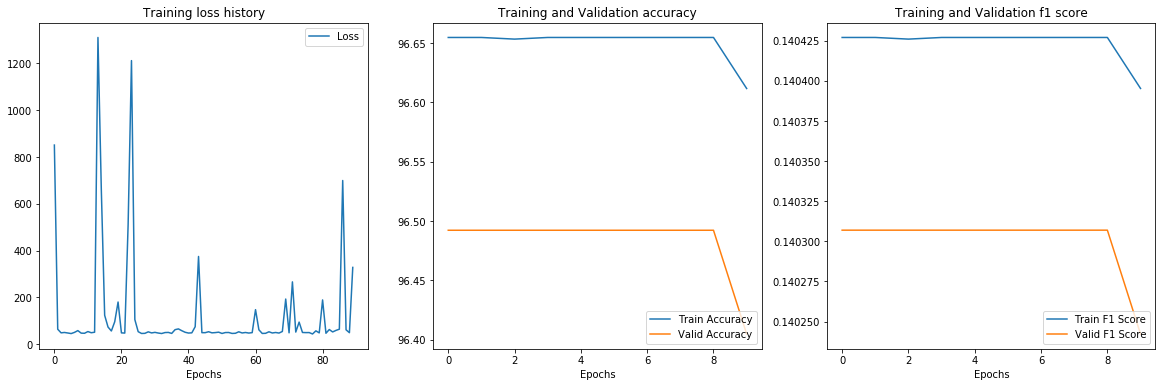

In [0]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))
axs[0].plot(loss_history, label='Loss')
axs[0].title.set_text("Training loss history")
axs[0].legend(loc="upper right")
axs[0].set_xlabel("Epochs")
axs[1].plot(train_acc, label='Train Accuracy')
axs[1].plot(val_acc, label='Valid Accuracy')
axs[1].title.set_text("Training and Validation accuracy")
axs[1].legend(loc="lower right")
axs[1].set_xlabel("Epochs")
axs[2].plot(train_f1_score, label='Train F1 Score')
axs[2].plot(val_f1_score, label='Valid F1 Score')
axs[2].title.set_text("Training and Validation f1 score")
axs[2].legend(loc="lower right")
axs[2].set_xlabel("Epochs")

### Best Model, no data augmentation

In [33]:
initial_lr = 0.0001
num_epochs = 10

resnet_model = resnet50()
resnet_model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet_model.parameters(), lr=initial_lr)

train_loader = torch.utils.data.DataLoader(
    malaria_train, batch_size=batch_size
)
valid_loader = torch.utils.data.DataLoader(
    malaria_valid, batch_size=batch_size
)
test_loader = torch.utils.data.DataLoader(
    malaria_test, batch_size=batch_size, shuffle=False
)

loss_history = []
train_acc = []
train_f1_score = []
val_acc = []
val_f1_score = []
for epoch in range(num_epochs):
    print("epoch {}".format(epoch+1))

    if epoch == 0:
        lr = initial_lr
    elif epoch % 2 == 0 and epoch != 0:
        lr *= 0.94
        optimizer = optim.Adam(resnet_model.parameters(), lr=lr)
    
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        # Data augmentation
        # Horizontal Flip
        # if torch.rand(1).item() > 0.5:
        #   inputs = inputs.flip(2)
        # Vertical Flip
        # if torch.rand(1).item() > 0.5:
        #   inputs = inputs.flip(3)
        # 90 rotation
        # if torch.rand(1).item() > 0.5:
        #   inputs = inputs.transpose(2, 3)
        # or 270 rotation
        # elif torch.rand(1).item() > 0.5:
        #   inputs = inputs.transpose(2, 3).flip(3)
        labels = labels.view(-1)
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = resnet_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        show_period = 250
        if i % show_period == show_period-1:    # print every "show_period" mini-batches
            print('[%d, %5d] loss: %.7f' %
                  (epoch + 1, i + 1, running_loss / show_period))
            loss_history.append(running_loss)
            running_loss = 0.0
        
    #validation part
    correct = 0
    total = 0
    each_correct = np.zeros(7)
    each_total = np.zeros(7)
    total_predicted = None
    total_labels = None
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.view(-1)
        outputs = resnet_model(inputs)
        
        _, predicted = torch.max(outputs.data, 1)
        if total_predicted is None:
          total_predicted = predicted
          total_labels = labels
        else:
          total_predicted = torch.cat((total_predicted, predicted), axis=0)
          total_labels = torch.cat((total_labels, labels), axis=0)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        for i in range(7):
          cur_idx = (labels == i).nonzero()
          cur_label = labels[cur_idx]
          cur_predicted = predicted[cur_idx]
          each_total[i] += cur_label.size(0)
          each_correct[i] += (cur_predicted == cur_label).sum().item()
    print("Training accuracy = {0:.3f}%".format(correct / total * 100))
    for i in range(7):
      print("{} label: Total={}, correct={}, acc={}".format(i,
                                                            each_total[i],
                                                            each_correct[i],
                                                            each_correct[i]/each_total[i]))
    train_acc.append(correct / total * 100)
    f1 = f1_score(total_labels.cpu().numpy(), total_predicted.cpu().numpy(), average="macro")
    print("Training f1 score = {0:.3f}".format(f1))
    train_f1_score.append(f1)

    correct = 0
    total = 0
    each_correct = np.zeros(7)
    each_total = np.zeros(7)
    total_predicted = None
    total_labels = None
    for i, data in enumerate(valid_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.view(-1)
        outputs = resnet_model(inputs)
        
        _, predicted = torch.max(outputs.data, 1)
        if total_predicted is None:
          total_predicted = predicted
          total_labels = labels
        else:
          total_predicted = torch.cat((total_predicted, predicted), axis=0)
          total_labels = torch.cat((total_labels, labels), axis=0)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        for i in range(7):
          cur_idx = (labels == i).nonzero()
          cur_label = labels[cur_idx]
          cur_predicted = predicted[cur_idx]
          each_total[i] += cur_label.size(0)
          each_correct[i] += (cur_predicted == cur_label).sum().item()
    print("Validation accuracy = {0:.3f}%".format(correct / total * 100))
    for i in range(7):
      print("{} label: Total={}, correct={}, acc={}".format(i,
                                                            each_total[i],
                                                            each_correct[i],
                                                            each_correct[i]/each_total[i]))
    val_acc.append(correct / total * 100)
    f1 = f1_score(total_labels.cpu().numpy(), total_predicted.cpu().numpy(), average="macro")
    print("Valid f1 score = {0:.3f}".format(f1))
    val_f1_score.append(f1)

print('Finished Training')

epoch 1
[1,   250] loss: 0.2590258
[1,   500] loss: 0.2160178
[1,   750] loss: 0.1833279
[1,  1000] loss: 0.1683499
[1,  1250] loss: 0.1525426
[1,  1500] loss: 0.1276858
[1,  1750] loss: 0.1297063
[1,  2000] loss: 0.1214598
[1,  2250] loss: 0.1108448
Training accuracy = 97.022%
0 label: Total=69690.0, correct=69612.0, acc=0.9988807576409815
1 label: Total=1326.0, correct=57.0, acc=0.042986425339366516
2 label: Total=160.0, correct=4.0, acc=0.025
3 label: Total=397.0, correct=262.0, acc=0.6599496221662469
4 label: Total=314.0, correct=6.0, acc=0.01910828025477707
5 label: Total=87.0, correct=13.0, acc=0.14942528735632185
6 label: Total=128.0, correct=1.0, acc=0.0078125
Training f1 score = 0.258
Validation accuracy = 96.842%
0 label: Total=7730.0, correct=7722.0, acc=0.9989650711513584
1 label: Total=147.0, correct=4.0, acc=0.027210884353741496
2 label: Total=19.0, correct=1.0, acc=0.05263157894736842
3 label: Total=44.0, correct=30.0, acc=0.6818181818181818
4 label: Total=39.0, correct=

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[2,   250] loss: 0.1049767
[2,   500] loss: 0.1155305
[2,   750] loss: 0.0975594
[2,  1000] loss: 0.0858968
[2,  1250] loss: 0.0939767
[2,  1500] loss: 0.0741849
[2,  1750] loss: 0.0773363
[2,  2000] loss: 0.0759249
[2,  2250] loss: 0.0776306
Training accuracy = 97.829%
0 label: Total=69690.0, correct=69537.0, acc=0.9978045630650022
1 label: Total=1326.0, correct=622.0, acc=0.46907993966817496
2 label: Total=160.0, correct=34.0, acc=0.2125
3 label: Total=397.0, correct=286.0, acc=0.7204030226700252
4 label: Total=314.0, correct=21.0, acc=0.06687898089171974
5 label: Total=87.0, correct=37.0, acc=0.42528735632183906
6 label: Total=128.0, correct=0.0, acc=0.0
Training f1 score = 0.422
Validation accuracy = 97.391%
0 label: Total=7730.0, correct=7704.0, acc=0.9966364812419146
1 label: Total=147.0, correct=61.0, acc=0.41496598639455784
2 label: Total=19.0, correct=2.0, acc=0.10526315789473684
3 label: Total=44.0, correct=27.0, acc=0.6136363636363636
4 label: Total=39.0, correct=2.0, acc=0.

In [34]:
# test part
correct = 0
total = 0
each_correct = np.zeros(7)
each_total = np.zeros(7)
total_predicted = None
total_labels = None
for i, data in enumerate(test_loader, 0):
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    labels = labels.view(-1)
    outputs = resnet_model(inputs)
    
    _, predicted = torch.max(outputs.data, 1)
    if total_predicted is None:
      total_predicted = predicted
      total_labels = labels
    else:
      total_predicted = torch.cat((total_predicted, predicted), axis=0)
      total_labels = torch.cat((total_labels, labels), axis=0)

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

    for i in range(7):
      cur_idx = (labels == i).nonzero()
      cur_label = labels[cur_idx]
      cur_predicted = predicted[cur_idx]
      each_total[i] += cur_label.size(0)
      each_correct[i] += (cur_predicted == cur_label).sum().item()
print("Test accuracy = {0:.3f}%".format(correct / total * 100))
for i in range(7):
  print("{} label: Total={}, correct={}, acc={}".format(i,
                                                        each_total[i],
                                                        each_correct[i],
                                                        each_correct[i]/each_total[i]))
f1 = f1_score(total_labels.cpu().numpy(), total_predicted.cpu().numpy(), average="macro")
print("Test f1 score = {0:.3f}".format(f1))

Test accuracy = 96.302%
0 label: Total=5614.0, correct=5607.0, acc=0.9987531172069826
1 label: Total=111.0, correct=61.0, acc=0.5495495495495496
2 label: Total=11.0, correct=2.0, acc=0.18181818181818182
3 label: Total=5.0, correct=0.0, acc=0.0
4 label: Total=169.0, correct=33.0, acc=0.1952662721893491
5 label: Total=0.0, correct=0.0, acc=nan
6 label: Total=12.0, correct=0.0, acc=0.0
Test f1 score = 0.358


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Text(0.5, 0, 'Epochs')

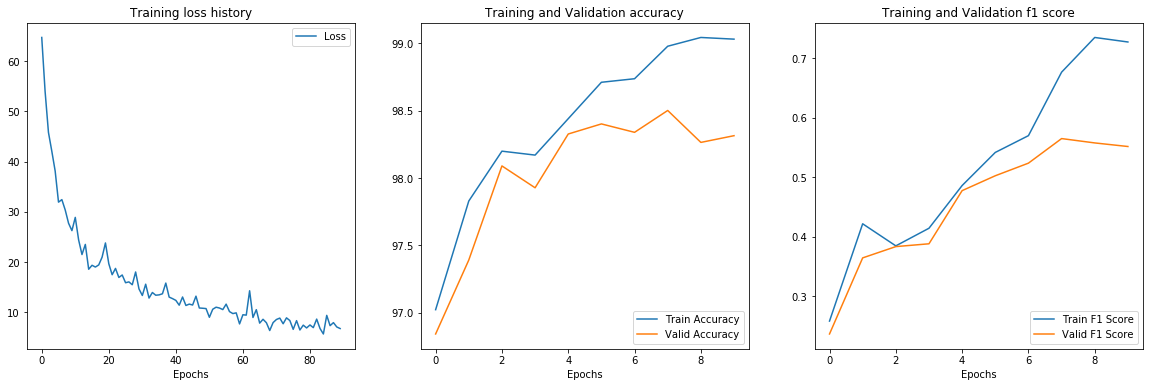

In [35]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))
axs[0].plot(loss_history, label='Loss')
axs[0].title.set_text("Training loss history")
axs[0].legend(loc="upper right")
axs[0].set_xlabel("Epochs")
axs[1].plot(train_acc, label='Train Accuracy')
axs[1].plot(val_acc, label='Valid Accuracy')
axs[1].title.set_text("Training and Validation accuracy")
axs[1].legend(loc="lower right")
axs[1].set_xlabel("Epochs")
axs[2].plot(train_f1_score, label='Train F1 Score')
axs[2].plot(val_f1_score, label='Valid F1 Score')
axs[2].title.set_text("Training and Validation f1 score")
axs[2].legend(loc="lower right")
axs[2].set_xlabel("Epochs")